In [1]:
import pandas as pd
from config import API_KEY
import csv; import numpy as np
import re; import warnings
import os
import googleapiclient.discovery
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
warnings.filterwarnings('ignore')
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
# Set up the YouTube Data API client
api_key = API_KEY
youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)

# Make a request to retrieve comments from a video

link1 = 'https://youtu.be/DY_qmk1BeMk'
splitlink = link1.split('/')
video_id = splitlink[3]

# Make a request to retrieve video details
video_request = youtube.videos().list(
    part='snippet',
    id=video_id
)
video_response = video_request.execute()

# Extract the video title
video_title = video_response['items'][0]['snippet']['title']
print(video_title)

# Request to retrieve comments (initial request)
request = youtube.commentThreads().list(
    part='snippet',
    videoId=video_id,
    order='relevance',
    maxResults=100  # Use the default maximum results per page
)
comment_response = request.execute()

# Get the nextPageToken to retrieve additional comments
next_page_token = comment_response.get('nextPageToken')

# Keep retrieving comments until there are no more pages or you reach the desired number of comments (200)
while next_page_token and len(comment_response['items']) < 200:
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        order='relevance',
        maxResults=100,  # Use the default maximum results per page
        pageToken=next_page_token
    )
    comment_response = request.execute()
    comment_response['items'].extend(comment_response['items'])
    next_page_token = comment_response.get('nextPageToken')

# Now, comment_response['items'] contains all 200 comments


Protestors Block Baby From Reaching The Hospital..


In [3]:
comments = []
for item in comment_response['items']:
    comment_data = {}
    comment_data['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
    comment_data['comments'] = item['snippet']['topLevelComment']['snippet']['textDisplay']
    comments.append(comment_data)
cleaning_data = pd.DataFrame(comments)


In [4]:
cleaning_data.to_csv(f'{video_title[:10]}top comments.csv')

In [5]:
comments_df = cleaning_data.copy()
comments_df.head()


,author,comments
0,ooki,POST MORE CONTENT PLS
1,Devkala Sharma,If they did this in asian countries police and...
2,Vito Gagliardi,🤦
3,Trevor Whitham,Make guns legal
4,celestial Goji productions,I don&#39;t get this whole stop oil protest


In [6]:
def convert_to_string(comments_df):
    comments_df["comment"]= comments_df["comments"].astype(str) 

convert_to_string(comments_df)

# Define a function to clean the text

def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
comments_df['Cleaned Reviews'] = comments_df['comments'].apply(clean)
comments_df.head()

,author,comments,comment,Cleaned Reviews
0,ooki,POST MORE CONTENT PLS,POST MORE CONTENT PLS,POST MORE CONTENT PLS
1,Devkala Sharma,If they did this in asian countries police and...,If they did this in asian countries police and...,If they did this in asian countries police and...
2,Vito Gagliardi,🤦,🤦,
3,Trevor Whitham,Make guns legal,Make guns legal,Make guns legal
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,I don&#39;t get this whole stop oil protest,I don t get this whole stop oil protest


In [7]:


# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

comments_df['POS tagged'] = comments_df['Cleaned Reviews'].apply(token_stop_pos)
comments_df.head()

,author,comments,comment,Cleaned Reviews,POS tagged
0,ooki,POST MORE CONTENT PLS,POST MORE CONTENT PLS,POST MORE CONTENT PLS,"[(POST, n), (CONTENT, n), (PLS, n)]"
1,Devkala Sharma,If they did this in asian countries police and...,If they did this in asian countries police and...,If they did this in asian countries police and...,"[(asian, a), (countries, n), (police, n), (civ..."
2,Vito Gagliardi,🤦,🤦,,[]
3,Trevor Whitham,Make guns legal,Make guns legal,Make guns legal,"[(Make, n), (guns, n), (legal, a)]"
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,I don&#39;t get this whole stop oil protest,I don t get this whole stop oil protest,"[(get, v), (whole, a), (stop, n), (oil, n), (p..."


In [8]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

comments_df['Lemma'] = comments_df['POS tagged'].apply(lemmatize)
comments_df.head()

,author,comments,comment,Cleaned Reviews,POS tagged,Lemma
0,ooki,POST MORE CONTENT PLS,POST MORE CONTENT PLS,POST MORE CONTENT PLS,"[(POST, n), (CONTENT, n), (PLS, n)]",POST CONTENT PLS
1,Devkala Sharma,If they did this in asian countries police and...,If they did this in asian countries police and...,If they did this in asian countries police and...,"[(asian, a), (countries, n), (police, n), (civ...",asian country police civilian beat merciless...
2,Vito Gagliardi,🤦,🤦,,[],
3,Trevor Whitham,Make guns legal,Make guns legal,Make guns legal,"[(Make, n), (guns, n), (legal, a)]",Make gun legal
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,I don&#39;t get this whole stop oil protest,I don t get this whole stop oil protest,"[(get, v), (whole, a), (stop, n), (oil, n), (p...",get whole stop oil protest


# Rule based method

### using textBlob

In [9]:
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [10]:
blob_data = pd.DataFrame(comments_df[['author','comment']])
blob_data['Subjectivity'] = blob_data['comment'].apply(getSubjectivity) 
blob_data['Polarity'] = blob_data['comment'].apply(getPolarity) 
blob_data['Analysis'] = blob_data['Polarity'].apply(analysis)
blob_data.head()


,author,comment,Subjectivity,Polarity,Analysis
0,ooki,POST MORE CONTENT PLS,0.5,0.50,Positive
1,Devkala Sharma,If they did this in asian countries police and...,0.5,-0.35,Negative
2,Vito Gagliardi,🤦,0.0,0.00,Neutral
3,Trevor Whitham,Make guns legal,0.2,0.20,Positive
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,0.4,0.20,Positive


In [11]:
tb_counts = blob_data.Analysis.value_counts()

### using VADER

In [12]:
analyzer = SentimentIntensityAnalyzer()
vader_data = pd.DataFrame(comments_df[['author','comment']])

# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
vader_data['Vader Sentiment'] = comments_df['comment'].apply(vadersentimentanalysis)


In [13]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
vader_data['Vader Analysis'] = vader_data['Vader Sentiment'].apply(vader_analysis)
vader_data.head()

,author,comment,Vader Sentiment,Vader Analysis
0,ooki,POST MORE CONTENT PLS,0.1477,Neutral
1,Devkala Sharma,If they did this in asian countries police and...,0.7851,Positive
2,Vito Gagliardi,🤦,0.0000,Neutral
3,Trevor Whitham,Make guns legal,0.1280,Neutral
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,-0.4939,Neutral


In [14]:
vd_counts = vader_data["Vader Analysis"].value_counts()

### using SentiWordNet

In [15]:
senti_data = pd.DataFrame(comments_df[['author','comment']])
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
            # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
            # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
        if not tokens_count:
            return 0
        if sentiment>0:
            return "Positive"
        if sentiment==0:
            return "Neutral"
        else:
            return "Negative"

senti_data['SWN analysis'] = comments_df['POS tagged'].apply(sentiwordnetanalysis)
senti_data.head()

,author,comment,SWN analysis
0,ooki,POST MORE CONTENT PLS,Neutral
1,Devkala Sharma,If they did this in asian countries police and...,Neutral
2,Vito Gagliardi,🤦,None
3,Trevor Whitham,Make guns legal,Positive
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,Positive


In [16]:
swn_counts = senti_data['SWN analysis'].value_counts()

([<matplotlib.patches.Wedge at 0x1e8bdaea350>,
 [Text(-0.7508084640855961, 0.8039195545932617, 'Neutral'),
  Text(0.6343483488390105, -0.8986668861848761, 'Positive'),
  Text(1.3374260223786236, -0.18382501098733459, 'Negative')],
 [Text(-0.4095318895012342, 0.4385015752326881, '73.9%'),
  Text(0.34600819027582386, -0.49018193791902326, '21.7%'),
  Text(0.8420830511272814, -0.11574167358461807, '4.3%')])

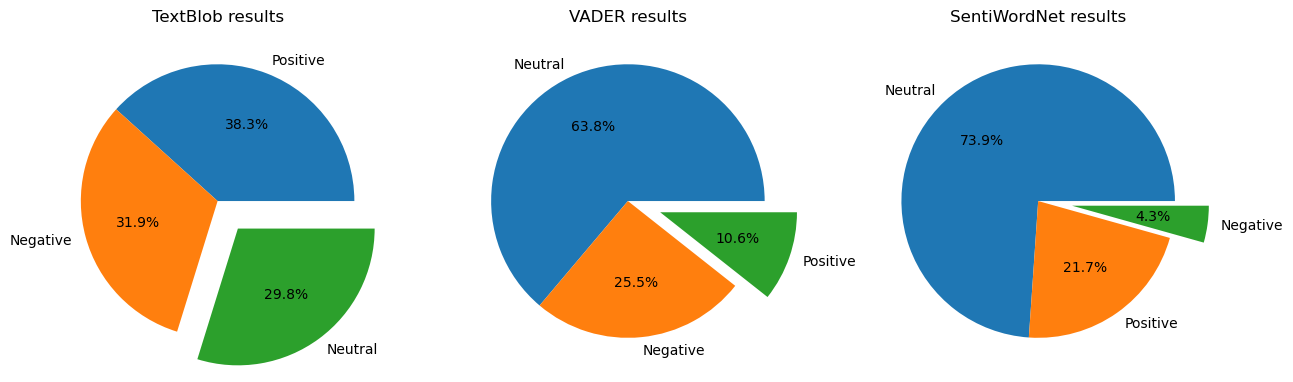

In [17]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vd_counts.values, labels = vd_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,3)
plt.title("SentiWordNet results")
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

# using machine learning models

In [18]:
# Load the TF-IDF MultinomialNB model and vectorizer
tfidf_nb_model = joblib.load('tfidf_nb_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the CountVectorizer MultinomialNB model and vectorizer
count_nb_model = joblib.load('count_nb_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')

# Load the TF-IDF Logistic Regression model and vectorizer
tfidf_lr_model = joblib.load('tfidf_lr_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the CountVectorizer Logistic Regression model and vectorizer
count_lr_model = joblib.load('count_lr_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')

# Load the TF-IDF LinearSVC model and vectorizer
tfidf_svc_model = joblib.load('tfidf_svc_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the CountVectorizer LinearSVC model and vectorizer
count_svc_model = joblib.load('count_svc_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')

# Load the TF-IDF Decision Tree model and vectorizer
tfidf_dt_model = joblib.load('tfidf_dt_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the CountVectorizer Decision Tree model and vectorizer
count_dt_model = joblib.load('count_dt_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')

# Load the TF-IDF Random Forest model and vectorizer
tfidf_rf_model = joblib.load('tfidf_rf_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the CountVectorizer Random Forest model and vectorizer
count_rf_model = joblib.load('count_rf_model.pkl')
count_vectorizer = joblib.load('count_vectorizer.pkl')


In [19]:
modelforcomm = comments_df.copy()


In [20]:
modelforcomm.head()

,author,comments,comment,Cleaned Reviews,POS tagged,Lemma
0,ooki,POST MORE CONTENT PLS,POST MORE CONTENT PLS,POST MORE CONTENT PLS,"[(POST, n), (CONTENT, n), (PLS, n)]",POST CONTENT PLS
1,Devkala Sharma,If they did this in asian countries police and...,If they did this in asian countries police and...,If they did this in asian countries police and...,"[(asian, a), (countries, n), (police, n), (civ...",asian country police civilian beat merciless...
2,Vito Gagliardi,🤦,🤦,,[],
3,Trevor Whitham,Make guns legal,Make guns legal,Make guns legal,"[(Make, n), (guns, n), (legal, a)]",Make gun legal
4,celestial Goji productions,I don&#39;t get this whole stop oil protest,I don&#39;t get this whole stop oil protest,I don t get this whole stop oil protest,"[(get, v), (whole, a), (stop, n), (oil, n), (p...",get whole stop oil protest


In [21]:
modelforcomm = modelforcomm.drop(columns = ['comment', 'author', 'comments', 'Cleaned Reviews', 'POS tagged'], axis = 1)


In [22]:
modelforcomm.head()

,Lemma
0,POST CONTENT PLS
1,asian country police civilian beat merciless...
2,
3,Make gun legal
4,get whole stop oil protest


In [23]:
modelforcomm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Lemma   94 non-null     object
dtypes: object(1)
memory usage: 880.0+ bytes


In [24]:
# Assuming you have loaded the models and vectorizers as shown earlier

# Assuming you have new data in the variable 'modelforcomm'
# Preprocess and vectorize the new data using the loaded vectorizer

# For TF-IDF vectorization
modelforcomm_tfidf = tfidf_vectorizer.transform(modelforcomm['Lemma'])

# For CountVectorizer vectorization
modelforcomm_count = count_vectorizer.transform(modelforcomm['Lemma'])

In [25]:
# Now, use the loaded models to make predictions on the vectorized new data

# For Multinomial Naive Bayes with TF-IDF
tfidf_nb_pred = tfidf_nb_model.predict(modelforcomm_tfidf)

# For Multinomial Naive Bayes with CountVectorizer
count_nb_pred = count_nb_model.predict(modelforcomm_count)

# For Logistic Regression with TF-IDF
tfidf_lr_pred = tfidf_lr_model.predict(modelforcomm_tfidf)

# For Logistic Regression with CountVectorizer
count_lr_pred = count_lr_model.predict(modelforcomm_count)

# For LinearSVC with TF-IDF
tfidf_svc_pred = tfidf_svc_model.predict(modelforcomm_tfidf)

# For LinearSVC with CountVectorizer
count_svc_pred = count_svc_model.predict(modelforcomm_count)

# For Decision Tree with TF-IDF
tfidf_dt_pred = tfidf_dt_model.predict(modelforcomm_tfidf)

# For Decision Tree with CountVectorizer
count_dt_pred = count_dt_model.predict(modelforcomm_count)

# For Random Forest with TF-IDF
tfidf_rf_pred = tfidf_rf_model.predict(modelforcomm_tfidf)

# For Random Forest with CountVectorizer
count_rf_pred = count_rf_model.predict(modelforcomm_count)

# Now, you have made predictions on the new data using the loaded models
# The predictions are stored in the respective variables (e.g., tfidf_nb_pred, count_nb_pred, etc.)
# You can use these predictions for further analysis, evaluation, or any other tasks as needed.


In [26]:
# For Multinomial Naive Bayes with TF-IDF
positive_nb_tfidf = (tfidf_nb_pred == 1.0).sum()
negative_nb_tfidf = (tfidf_nb_pred == 0.0).sum()
print(f"Multinomial Naive Bayes TF-IDF: Positive={positive_nb_tfidf}, Negative={negative_nb_tfidf}")
print("Good video" if positive_nb_tfidf > negative_nb_tfidf else "Bad video")

# For Multinomial Naive Bayes with CountVectorizer
positive_nb_count = (count_nb_pred == 1.0).sum()
negative_nb_count = (count_nb_pred == 0.0).sum()
print(f"Multinomial Naive Bayes CountVectorizer: Positive={positive_nb_count}, Negative={negative_nb_count}")
print("Good video" if positive_nb_count > negative_nb_count else "Bad video")

# For Logistic Regression with TF-IDF
positive_lr_tfidf = (tfidf_lr_pred == 1.0).sum()
negative_lr_tfidf = (tfidf_lr_pred == 0.0).sum()
print(f"Logistic Regression TF-IDF: Positive={positive_lr_tfidf}, Negative={negative_lr_tfidf}")
print("Good video" if positive_lr_tfidf > negative_lr_tfidf else "Bad video")

# For Logistic Regression with CountVectorizer
positive_lr_count = (count_lr_pred == 1.0).sum()
negative_lr_count = (count_lr_pred == 0.0).sum()
print(f"Logistic Regression CountVectorizer: Positive={positive_lr_count}, Negative={negative_lr_count}")
print("Good video" if positive_lr_count > negative_lr_count else "Bad video")

# For LinearSVC with TF-IDF
positive_svc_tfidf = (tfidf_svc_pred == 1.0).sum()
negative_svc_tfidf = (tfidf_svc_pred == 0.0).sum()
print(f"LinearSVC TF-IDF: Positive={positive_svc_tfidf}, Negative={negative_svc_tfidf}")
print("Good video" if positive_svc_tfidf > negative_svc_tfidf else "Bad video")

# For LinearSVC with CountVectorizer
positive_svc_count = (count_svc_pred == 1.0).sum()
negative_svc_count = (count_svc_pred == 0.0).sum()
print(f"LinearSVC CountVectorizer: Positive={positive_svc_count}, Negative={negative_svc_count}")
print("Good video" if positive_svc_count > negative_svc_count else "Bad video")

# For Decision Tree with TF-IDF
positive_dt_tfidf = (tfidf_dt_pred == 1.0).sum()
negative_dt_tfidf = (tfidf_dt_pred == 0.0).sum()
print(f"Decision Tree TF-IDF: Positive={positive_dt_tfidf}, Negative={negative_dt_tfidf}")
print("Good video" if positive_dt_tfidf > negative_dt_tfidf else "Bad video")

# For Decision Tree with CountVectorizer
positive_dt_count = (count_dt_pred == 1.0).sum()
negative_dt_count = (count_dt_pred == 0.0).sum()
print(f"Decision Tree CountVectorizer: Positive={positive_dt_count}, Negative={negative_dt_count}")
print("Good video" if positive_dt_count > negative_dt_count else "Bad video")

# For Random Forest with TF-IDF
positive_rf_tfidf = (tfidf_rf_pred == 1.0).sum()
negative_rf_tfidf = (tfidf_rf_pred == 0.0).sum()
print(f"Random Forest TF-IDF: Positive={positive_rf_tfidf}, Negative={negative_rf_tfidf}")
print("Good video" if positive_rf_tfidf > negative_rf_tfidf else "Bad video")

# For Random Forest with CountVectorizer
positive_rf_count = (count_rf_pred == 1.0).sum()
negative_rf_count = (count_rf_pred == 0.0).sum()
print(f"Random Forest CountVectorizer: Positive={positive_rf_count}, Negative={negative_rf_count}")
print("Good video" if positive_rf_count > negative_rf_count else "Bad video")


Multinomial Naive Bayes TF-IDF: Positive=18, Negative=76
Bad video
Multinomial Naive Bayes CountVectorizer: Positive=16, Negative=78
Bad video
Logistic Regression TF-IDF: Positive=56, Negative=38
Good video
Logistic Regression CountVectorizer: Positive=52, Negative=42
Good video
LinearSVC TF-IDF: Positive=50, Negative=44
Good video
LinearSVC CountVectorizer: Positive=66, Negative=28
Good video
Decision Tree TF-IDF: Positive=74, Negative=20
Good video
Decision Tree CountVectorizer: Positive=56, Negative=38
Good video
Random Forest TF-IDF: Positive=86, Negative=8
Good video
Random Forest CountVectorizer: Positive=74, Negative=20
Good video
